In [1]:
!gdown --id 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /content/dataset.zip
100% 2.35M/2.35M [00:00<00:00, 235MB/s]


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

#### 1. Read Dataset

In [4]:
dataset_path = 'dataset/weatherHistory.csv'
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [6]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']
univariate_df.head()

,Temperature (C)
Formatted Date,
2006-04-01 00:00:00.000 +0200,9.472222
2006-04-01 01:00:00.000 +0200,9.355556
2006-04-01 02:00:00.000 +0200,9.377778
2006-04-01 03:00:00.000 +0200,8.288889
2006-04-01 04:00:00.000 +0200,8.755556


In [7]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []

    window_size = input_size + offset

    if df_end_idx == None:
        df_end_idx = len(df) - window_size

    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size

        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]

        features.append(feature)
        labels.append(label)

    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)

    return features, labels

#### 2. Split Train - Valid - Test

In [8]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int((train_size + val_size) * dataset_length)

X_train, y_train= slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

#### 3. Build Pytorch Dataset

In [9]:
class WeatherForecasting(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.transform:
            x = self.transform(x)

        X = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

In [10]:
train_dataset = WeatherForecasting(X_train, y_train)
val_dataset = WeatherForecasting(X_val, y_val)
test_dataset = WeatherForecasting(X_test, y_test)

In [11]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#### 3. Build Model

In [12]:
class WeatherForecastModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, droupout_prob):
        super(WeatherForecastModel, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(droupout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [13]:
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [14]:
model = WeatherForecastModel(embedding_dim=embedding_dim, hidden_size=hidden_size, n_layers=n_layers, droupout_prob=dropout_prob)
model.to(device)

WeatherForecastModel(
  (rnn): RNN(1, 8, num_layers=3, batch_first=True)
  (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#### 4. Training

In [16]:
def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [17]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [18]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, epochs, device)

Epoch: 1/50 | Train Loss: 126.7144 | Val Loss: 46.5478
Epoch: 2/50 | Train Loss: 29.9093 | Val Loss: 7.9062
Epoch: 3/50 | Train Loss: 16.1273 | Val Loss: 3.1808
Epoch: 4/50 | Train Loss: 13.1546 | Val Loss: 2.7983
Epoch: 5/50 | Train Loss: 11.6122 | Val Loss: 1.8905
Epoch: 6/50 | Train Loss: 10.6032 | Val Loss: 1.6222
Epoch: 7/50 | Train Loss: 10.1788 | Val Loss: 1.5360
Epoch: 8/50 | Train Loss: 9.6495 | Val Loss: 1.6335
Epoch: 9/50 | Train Loss: 9.3395 | Val Loss: 1.8780
Epoch: 10/50 | Train Loss: 9.1364 | Val Loss: 1.5028
Epoch: 11/50 | Train Loss: 8.8933 | Val Loss: 1.3691
Epoch: 12/50 | Train Loss: 8.8007 | Val Loss: 1.3753
Epoch: 13/50 | Train Loss: 8.4925 | Val Loss: 2.0089
Epoch: 14/50 | Train Loss: 8.4098 | Val Loss: 1.7220
Epoch: 15/50 | Train Loss: 8.2465 | Val Loss: 1.5244
Epoch: 16/50 | Train Loss: 7.8910 | Val Loss: 1.8047
Epoch: 17/50 | Train Loss: 7.8164 | Val Loss: 1.3346
Epoch: 18/50 | Train Loss: 7.7346 | Val Loss: 1.8528
Epoch: 19/50 | Train Loss: 7.5003 | Val Loss: 

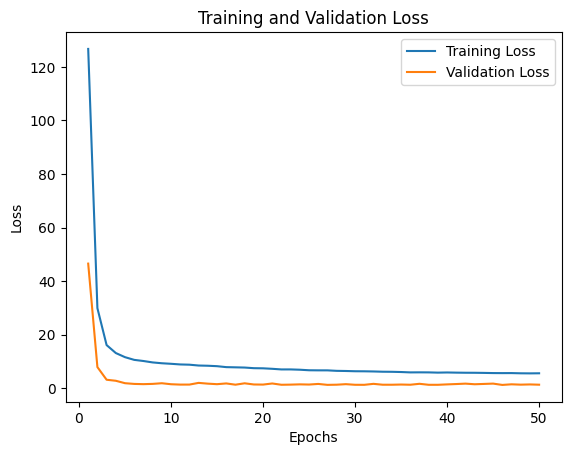

In [19]:
# prompt: visualize plot train_loss and val_loss

import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1) # Assuming epochs is defined

plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### 5. Evaluate Model

In [23]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print(f'Valid Loss: {val_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Valid Loss: 1.3313
Test Loss: 1.3313


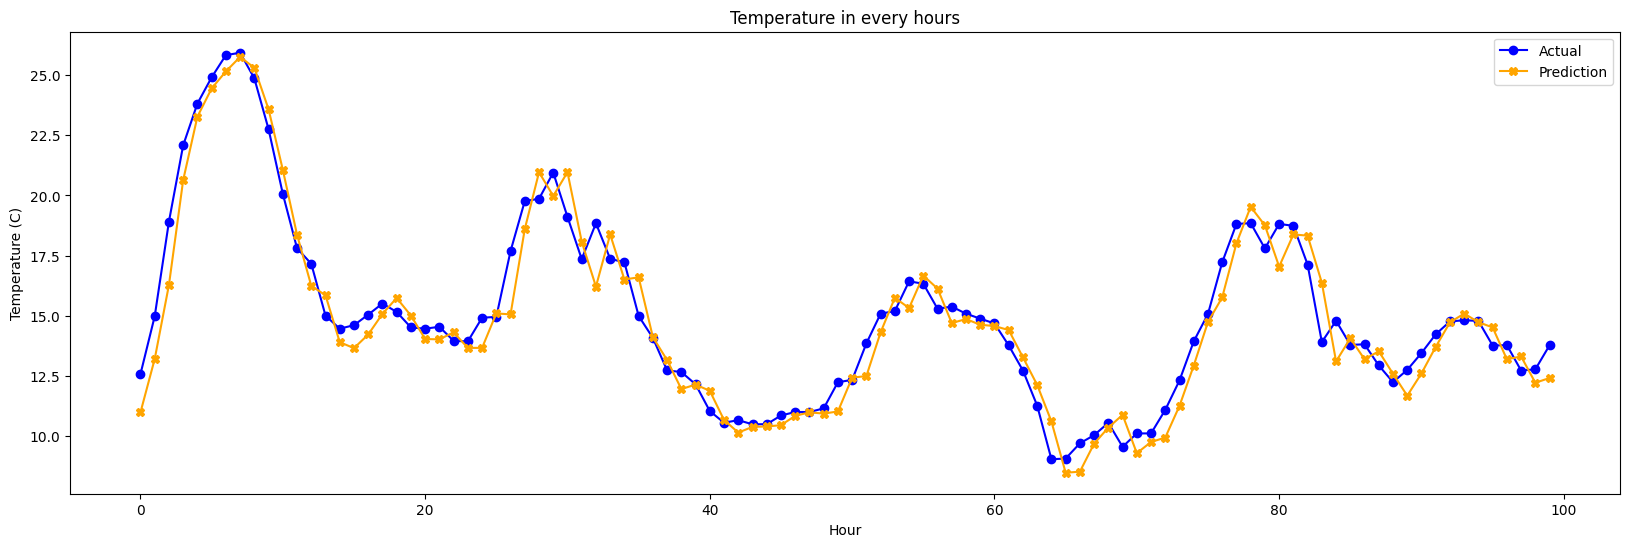

In [24]:
def plot_difference(y, pred):
    plt.figure(figsize=(20,6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()
    plt.plot(times, y_to_plot, color='blue', marker='o', label='Actual')
    plt.plot(times, pred_to_plot, color='orange', marker='X', label='Prediction')
    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()


inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)